# Imports

In [1]:
import os
import requests
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

from dataanalyser import DataAnalyser
from simulationanalyser import SimulationAnalyser

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# General

**Standaard voor elk project**  
- profiel elektriciteitsvraag (indien meer assets dan laadpalen en warmtepomp, dwz voor assets die we niet controleren)
- profiel zonne-instraling
- profiel elektriciteitsprijs

**Bijkomend indien warmte**  
- profiel warmtevraag
- Indien variabele warmtebronnen: profiel van warmteaanbod
- Indien warmtepomp op basis van buffer: profiel van input debiet naar buffer

**Bijkomend indien EV**
Voor EV load profiles is, als ik het model van Imec goed lees, het volgende nodig:
- profiel voor arrival times, duration times and total energy charged van laadsessies (input voor machine learning model van Imec: http://users.atlantis.ugent.be/cdvelder/papers/2020/lahariya2020energies.pdf
and https://github.com/mlahariya/EV-SDG)

**Projectspecifieke parameters**
- parameter range voor batterij (capaciteit, max op/ontlaadvermogen…)
- parameter range voor PV installatie (oriëntatie, inclinatie, type zonnepanelen, aantal panelen…)
- parameter range voor warmtepomp (capaciteit, compressietrappen, COP-waarden…)
- Indien warmtepomp op basis van buffer: parameter range voor buffer ((max/min)volume, max/min debieten…)
- Inschatting investeringskost voor assets (bvb battery of PV per kWh...)

**Output**  
Voor elk gelopen scenario:
- CAPEX en OPEX
- Percentages eigen verbruik en zelf-voorzienendheid (opgesplitst per energiebron, voor elektriciteit en warmte)


# Description: Tuin van Eden

Project will be executed in several phases, main question is what investments to make during what phase. First.

Assumptions see also [Dropbox](https://www.dropbox.com/work/Circular/006%20Projecten/Tuin%20van%20Eden/Haalbaarheidsscan/EMS?preview=TVE_SimulatieParameters.xlsx):
* Battery maximum power: 30 kW (not 50, since the batteries used here are a lot smaller)
* Use prices for 2022
* Use grid for charging battery only in January, in April and July, use 'current values' control
* For assumptions on EV charging profiles, see further)

Suggested scenarios, in words:
1. Start with max amount of pv possible, small battery and small number of charging station users; in phase two, the number of charging station users increases, but no additional investments are made. The probability of finding a charging station goes down. Same for the third phase.
2. Start with max amount of pv possible, medium battery and small number of charging station users; in phase two, additional investments to double PV capacity and increase number of charging stations. #CS users also increases, so equal chance of finding a spot. Same for third phase.
3. Start with max amount of pv possible, medium battery and small number of charging station users; in phase two, additional investments to double PV capacity, number of charging stations remains equal. #CS users increases, so lower chance of finding a spot. Same for third phase
4. Start with max amount of pv possible, medium battery and small number of charging station users; in phase two, additional investments to double PV capacity, number of charging stations remains equal. #CS users increases, so lower chance of finding a spot. Third phase: PV capacity remains equal, but number of charging stations is increase; #CS users keeps increasing as well.

Phase 1: 
* 55 inhabitants
* PV: 62.5 kWp, 400 kWp per panel, installation split equally over east, south, west: 52 400 kWp panels in each direction
* PV to battery ratios of 1 and 3 were optimal for previous project, so simulate those
* Thermal energy demand (and related electricity demand heat pump with COP 4.5) based on simulation tool Jonas
* Base load 3 kW
* Charging stations: electricity consumption is more based on number of users than number of charging stations, although we can define a probabilty of finding a free charging pole (e.g low number of poles, low probability of finding a pole) in the profile generation tool.


Battery storage capacity | Installed solar capacity | #Charging stations | Remarks | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------|---------
20.8 | 62.5 | 26 | Do we want this scenario? Assuming additional PV in future phases, this battery will soon become too small
62.5 | 62.5 | 26 | 
125 | 62.5 | 26 | Add this to then compare if it is worthwhile in the coming phases

**Phase 2**
* XX inhabitants
* 

Battery storage capacity | Installed solar capacity | #Charging stations | Remarks | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------|---------
62.5 | 125 | 26 | 
62.5 | 250 | 26 | Is this realistic, i.e. can we have this much solar in phase 2?
62.5 | 125 | 85 |
62.5 | 250 | 85 | Is this realistic, i.e. can we have this much solar in phase 2?
125 | 125 | 26 | 
125 | 250 | 26 | Is this realistic, i.e. can we have this much solar in phase 2?
125 | 125 | 85 |
125 | 250 | 85 | Is this realistic, i.e. can we have this much solar in phase 2?

**Phase 3** 


Battery storage capacity | Installed solar capacity | Price year | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------
0 | 75 | 2022 | Apr 
0 | 150 | 2022 | Apr 
0 | 225 | 2022 | Apr 

# Generate data

In [5]:
start_time = "2022-01-01 00:00"
end_time = "2022-12-31 23:59"

**Make sure to use files only as long as the simulation, i.e. a month** to limit simulation time

In [4]:
path_to_project = '/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/'
path_to_data_files = os.path.join(path_to_project, '01_jan')
# CSV should have comma as a separator and . as a decimal separator!

## Price data

Use 2022 prices (below code is for adjusting 2021 prices)

In [79]:
price = pd.read_csv(os.path.join(path_to_project, '2021_Price_1h_europerWh.csv'), index_col='Time', parse_dates=True)
price.loc[datetime.datetime(2021, 1, 1):datetime.datetime(2021, 6, 3, 14, 15), 'price'] = \
                price.loc[datetime.datetime(2021, 1, 1):datetime.datetime(2021, 6, 3, 14, 15), 'price'] / 1e6

In [81]:
price.to_csv(os.path.join(path_to_project, '2021_Price_1h.csv'))

## Weather data

Use the generator tool to generate weather data for 2021 based on the tmy file

## Electricity demand data

Only electricity use is heat pump and charging stations; 
* Heat pump electricity use is assumed from heat profile and COP of 4.5
* The charging station profile is generated using [RAMP-mobility](https://github.com/RAMP-project/RAMP-mobility/blob/master/docs/getting_started.md), with the following adjustments from default:
    * The **population shares** are 'working': 0, 'student': 0 and 'inactive': 1; this ensures only the active driving windows of the inactive profile (see next point) are used.
    * The **driving window** for the inactive profile is adjusted to simulate the main driving activity only in the afternoon, when people return from work, and ignores the morning main driving activity (cars are assumed to be charging elsewhere then)
    * Only a part of the total amount of **driven kilometers per day** (standard in RAMP for BE: 50 in the week, 60 in the weekend) is charged at home. Additionally, our assumption is 30 km/d of driving demand, of which half is charged at home. This effectively means adjusting the values for France (taken to be representative for Belgium) in d_tot.csv, in this case reducing them by more than a factor three. Actually used values: 15 km/d for weekdays, 18 km/d for weekends.
    * [Not required: Since the power consumption of a car is dependent on it's velocity, calculated as the trip distance divided by the **trip time**, these need to be adjusted downwards as well in the d_min and t_func files, equally with a factor of 50/15 resp 60/18 for the weekend (both equal 3.33).]
    * The **nominal power** of the charging station is assumed to be 11 kW
    * The **'Uncontrolled' setting** is used to generate the profile
    * With 55 charging stations, the **number of actual users** is assumed to be 55 (private charging stations), so a very high chance of always being able to charge (1.0)
    * **Temperature data** of the correct year is required, so convert the temperature data in the weather file to csv
    
    => This whole approach gives a total electricity demand that is a lot lower than expected (e.g., 10 MWh per year for 26 users,  while approx. 26 * 15km/d * 18kWh/100km * 365d/year = 25MWh is expected); so, use 135 users in RAMP to mimic 55 users.
* Add a baseload to the profile as well.

In [2]:
base_load = 3000

In [38]:
with open('./data/SimulationData/Weather/weather_data_2021_15m.json') as jsonfile:
    data = json.load(jsonfile)
data = pd.DataFrame(data['temperature'].values(), index=data['temperature'].keys(), columns=['BE'])
data.set_index(pd.to_datetime(data.index), inplace=True)
data = data.resample('H').mean()
data = data.loc[datetime.datetime(2021,1,1):datetime.datetime(2021,12,31,23,59)]
data.to_csv('./data/SimulationData/Weather/temperature_data_2021_1h.csv')

[Run RAMP model]

In [25]:
nr_cars = 135

In [26]:
ev_data = pd.read_csv(os.path.join(path_to_project, f'EVdataTuinvanEden_{nr_cars}lp.csv'),
                      index_col='Unnamed: 0',
                      parse_dates=True)

In [27]:
ev_data = ev_data.reindex(ev_data.index.append(pd.date_range(datetime.datetime(2023,1,1), 
                                                             datetime.datetime(2023,1,1,23), freq='T',
                                                             tz='utc')))

In [28]:
ev_data = ev_data.resample('H').mean() * 1000

In [29]:
cop = 4.5
heat_demand = pd.read_csv(os.path.join(path_to_project, 'HeatDemandTuinvanEden.csv'))
heat_demand_data = pd.DataFrame(index=pd.date_range(datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M'), 
                                                    datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M')+datetime.timedelta(days=1), freq='H', tz='utc'),
                       data=heat_demand['load'].values,
                       columns=['heatdemand_load'])
heat_demand_data['heatpump_load'] = heat_demand_data['heatdemand_load'] / cop

In [30]:
total_load_data = ev_data.join(heat_demand_data)

In [31]:
total_load_data['total_load'] = total_load_data['Charging Profile'] + total_load_data['heatpump_load']

<Axes: >

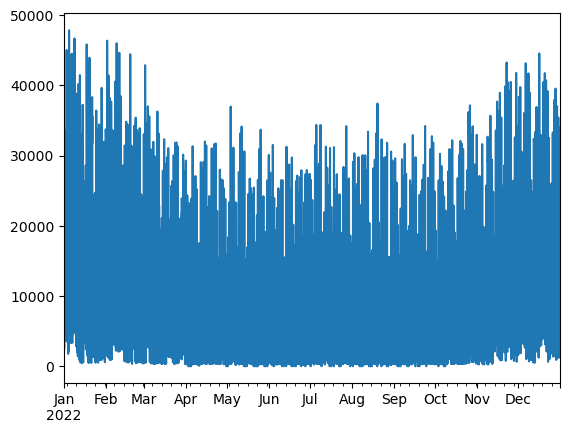

In [32]:
total_load_data['total_load'][start_time:end_time].plot()

In [33]:
electricity_load_data_path = os.path.join(path_to_project, f'total_load_data_TuinvanEden_{nr_cars}lp.csv')

In [34]:
total_load_data['total_load'].to_csv(electricity_load_data_path)

In [6]:
storage_battery = 20800.0
installed_pv = 62500.0
initial_state_of_charge = 20.0
initial_battery_power = 0.0

In [93]:
watt_per_panel = 400
nr_panels = int(installed_pv/watt_per_panel)
nr_panels_per_wind_direction = int(nr_panels/3)

# Analyse

In [6]:
simulation_name = 'tuinvaneden'
path_to_project = '/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/'
path_to_data_files = os.path.join(path_to_project, '01_jan')
path_to_results_files = os.path.join(path_to_project, 'SimulationResults')
simulations = [{'month': 'jan', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'feb', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'mar', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'apr', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'may', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'jun', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'jul', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'aug', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'sep', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'oct', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'nov', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022},
               {'month': 'dec', 'battery_storage': 62, 'pv': 62, 'lp': 135, 'price': 2022}]

battery=True
heat_pump=False
investment_cost_battery = 540 #€/kWh
investment_cost_pv = 918.75 #€/kWh
investment_cost_other = 20000 #€/kWh
opex = 3000.0
discounting_time = 15 #year
injection_price = 4.3*1e-3

In [7]:
simulation_results = []
for sim in simulations:
    file = os.path.join(path_to_results_files, 
                        f"{simulation_name}_{sim.get('month')}_batt{sim.get('battery_storage')}_pv{sim.get('pv')}_lp{sim.get('lp')}_price{sim.get('price')}.csv")
    print(f"Reading and analysing {file}...")
    
    sim['battery_CAPEX'] = sim.get('battery_storage') * investment_cost_battery
    sim['pv_CAPEX'] = sim.get('pv') * investment_cost_pv
    sim['total_CAPEX'] = sim['battery_CAPEX'] + sim['pv_CAPEX'] + investment_cost_other
    sim['monthly_cost'] = (sim['total_CAPEX'] + opex) / 12 / discounting_time
                        
    simulationanalyser = SimulationAnalyser(file)
    sim['simulationanalyser'] = simulationanalyser
    
    # Get data in right units, i.e. kWh
    w_to_kwh = ['pvinstallation_east_power', 'pvinstallation_south_power', 
                'pvinstallation_west_power', 'eldemand_total_load']
    if heat_pump and sim.get('battery_storage') != 0:
        w_to_kwh.append(['electricity demand_heatpump_load', 'heat demand_load', 
                         'heatpump_electric_power', 'heatpump_thermal_power'])
    simulationanalyser.data[w_to_kwh] = simulationanalyser.data[w_to_kwh] / 4000 # W to kWh
    simulationanalyser.data['price_price'] = simulationanalyser.data['price_price'] * 1000 # €/Wh to €/kWh
    
    if battery and sim.get('battery_storage') != 0:
        simulationanalyser.data['battery_power'] = simulationanalyser.data['battery_power'].shift(-1)*-1 / 4000.0 # W to kWh
    
    sim['total pv'] = simulationanalyser.calculate_total_pv(['pvinstallation_east_power',
                                                                   'pvinstallation_south_power', 
                                                                   'pvinstallation_west_power'])
    sim['total demand'] = simulationanalyser.calculate_total_demand(['eldemand_total_load',
                                                                     'eldemand_heatpump_load'])
    sim['selfconsumption pv'] = simulationanalyser.calculate_self_consumption_pv('pv total power',
                                                                                 'eldemand total power')
    
    if battery and sim.get('battery_storage') != 0:
        sim['total grid demand'] = simulationanalyser.get_total_grid_consumption('pv total power',
                                                                              'eldemand total power', 
                                                                              'battery_power')
        sim['selfconsumption'] = simulationanalyser.calculate_self_consumption('pv total power',
                                                                           'battery_power',
                                                                           'eldemand total power')
        sim['battery storage solar'] = simulationanalyser.get_battery_storage_solar('pv total power',
                                                                                    'battery_power',
                                                                                    'eldemand total power')
        sim['battery storage grid'] = simulationanalyser.get_battery_storage_grid('pv total power',
                                                                                  'battery_power',
                                                                                  'eldemand total power')
        sim['total costs'] = simulationanalyser.get_total_costs('pv total power', 
                                                                'eldemand total power',
                                                                'price_price',
                                                                'battery_power')
        sim['total costs no ems'] = sum(simulationanalyser.data['demand costs no ems'])
        sim['total costs battery charging'] = sum(simulationanalyser.data['battery charging costs'])
        sim['total savings'] = simulationanalyser.get_total_savings('pv total power', 
                                                                    'eldemand total power',
                                                                    'price_price', 
                                                                    'battery_power') 
        sim['total savings battery discharging'] = sum(simulationanalyser.data['avoided costs battery'])
        sim['injected'] = simulationanalyser.get_injection('pv total power', 
                                                           'eldemand total power', 
                                                           'battery_state_of_charge')
        sim['injected profit'] = simulationanalyser.get_injection('pv total power', 
                                                                  'eldemand total power', 
                                                                  'battery_state_of_charge',
                                                                  'price_price')
    else:
        sim['total grid demand'] = simulationanalyser.get_total_grid_consumption('pv total power',
                                                                              'eldemand total power')
        sim['selfconsumption'] = sim['selfconsumption pv']
        sim['total costs'] = simulationanalyser.get_total_costs('pv total power', 
                                                                'eldemand total power',
                                                                'price_price')
        sim['total costs no ems'] = sum(simulationanalyser.data['demand costs no ems'])
        sim['total savings'] = simulationanalyser.get_total_savings('pv total power', 
                                                                    'eldemand total power',
                                                                    'price_price') 
        sim['injected'] = simulationanalyser.get_injection('pv total power', 
                                                           'eldemand total power')
        sim['injected profit'] = simulationanalyser.get_injection('pv total power', 
                                                                  'eldemand total power', 
                                                                  'price_price')
    sim['peak grid demand'] = max(simulationanalyser.data['total grid demand']) * 4  # kWh to kW
    sim['peak grid demand no ems'] = max(simulationanalyser.data['eldemand total power']) * 4  # kWh to kW
    simulation_results.append(sim)

Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_jan_batt62_pv62_lp135_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_feb_batt62_pv62_lp135_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_mar_batt62_pv62_lp135_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_apr_batt62_pv62_lp135_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_may_batt62_pv62_lp135_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinVanEden/SimulationResults/tuinvaneden_j

In [8]:
simulationanalyser.data.columns

Index(['timestamp', 'temperature', 'total_horizontal_irradiation',
       'diffuse_horizontal_irradiation', 'actions_heatpump_operation_modus',
       'actions_heatpump_compression_states', 'actions_heatpump_temp_setpoint',
       'actions_heatpump_flow_setpoint', 'actions_battery_system_status',
       'actions_battery_real_power', 'actions_battery_reactive_power',
       'actions_battery_reason', 'actions_chargingstation_totalpower',
       'actions_reset_heatpump_timer', 'actions_distr_heat_temp_sp',
       'costs_discounted_cost_calculated', 'costs_pv', 'costs_battery',
       'costs_base_cs', 'costs_grid_cs', 'costs_cs_cost_calculated',
       'costs_base_el', 'costs_grid_el', 'costs_grid_only_solar',
       'costs_el_cost_calculated', 'costs_savings_calculated',
       'costs_el_savings', 'costs_cs_savings', 'costs_el_savings_wout_battery',
       'costs_heat_cost_calculated', 'battery_state_of_charge',
       'battery_battery_status', 'battery_battery_operating_status',
       '

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


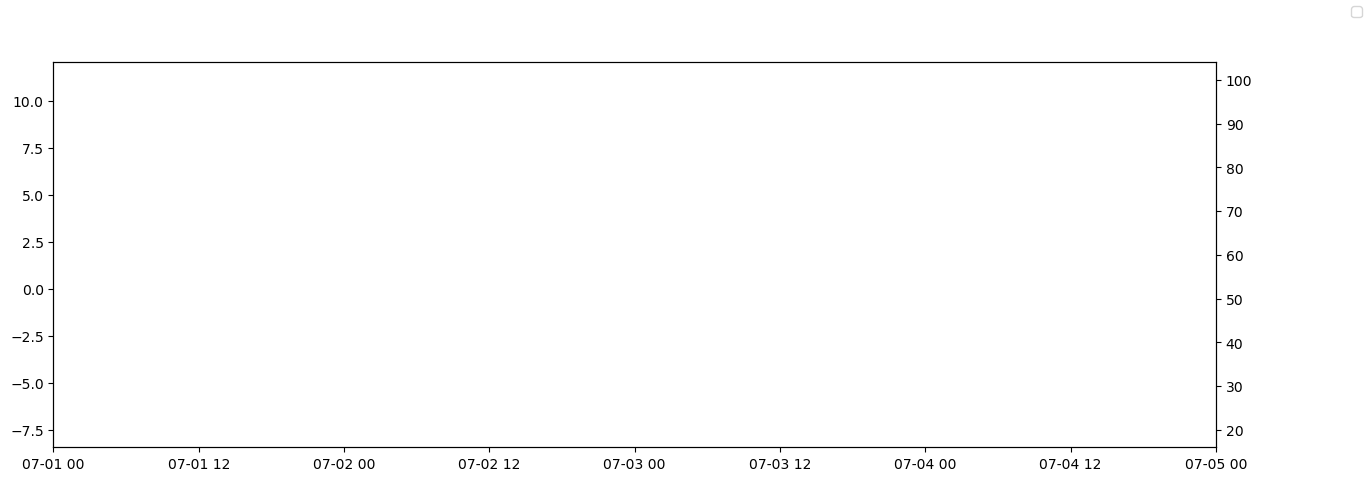

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(simulationanalyser.data['eldemand total power'])
ax.plot(simulationanalyser.data['pv total power'])
ax.plot(simulationanalyser.data['battery_power'])

ax2 = ax.twinx()
ax2.plot(simulationanalyser.data['battery_state_of_charge'])
#ax2.plot(simulationanalyser.data['price_price'], 'r')
ax.set_xlim(datetime.datetime(2022,7,1), datetime.datetime(2022,7,5))
fig.legend()

In [40]:
sum(simulationanalyser.data['total grid demand'])

113.46791566563665

In [10]:
results_df = pd.DataFrame(simulation_results)

In [11]:
results_df

,month,battery_storage,pv,lp,price,battery_CAPEX,pv_CAPEX,total_CAPEX,monthly_cost,simulationanalyser,...,battery storage grid,total costs,total costs no ems,total costs battery charging,total savings,total savings battery discharging,injected,injected profit,peak grid demand,peak grid demand no ems
0,jan,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,2.593965e+03,1843.974005,2228.624107,3.855065e+02,770.044235,558.373696,9.315764,1.619816,73.028424,47.846092
1,feb,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,2.585091e+03,1174.823576,1563.493788,3.327599e+02,721.405671,488.138195,139.098978,19.203999,57.166693,46.368670
2,mar,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,2.056938e+03,1262.266623,2039.725857,4.213521e+02,1198.552080,648.956237,1004.587951,184.761561,48.832951,42.869829
3,apr,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.283244e-13,151.315437,977.846463,2.076254e-14,826.206900,306.693801,1051.893123,166.317600,24.445464,32.014527
4,may,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.061308e-13,111.305778,799.508513,1.764220e-14,688.080704,253.722693,1937.492460,246.676365,27.528445,36.981144
5,jun,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.066525e-13,104.191806,1013.345896,2.161597e-14,909.129738,311.518985,1299.916153,252.351499,23.270482,31.518024
6,jul,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.372548e-13,107.562841,1493.826782,3.994358e-14,1386.232689,473.431456,1496.334806,378.083448,22.283837,34.367682
7,aug,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.119799e-13,207.421637,2165.704785,4.732364e-14,1957.864631,669.932923,1505.279068,563.667092,14.460590,37.417478
8,sep,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.079727e-13,463.385598,1623.068493,3.829780e-14,1159.601026,439.902331,445.897320,146.447201,29.083115,34.217562
9,oct,62,62,135,2022,33480,56962.5,110442.5,630.236111,<simulationanalyser.SimulationAnalyser object ...,...,1.732081e+03,540.453089,954.126943,2.025742e+02,616.239242,335.426079,778.074893,124.541656,52.765235,37.148711


In [12]:
pd.DataFrame(simulation_results).to_csv('./TuinVanEden_simulation_results_135lp_year.csv')

In [44]:
lp26_second_attempt = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_26lp_second_attempt.csv')
#lp26 = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_26lp.csv')
#lp55 = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_55lp.csv')
#lp85 = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_85lp.csv')
lp135 = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_135lp.csv')
#lp190 = pd.read_csv('/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/TuinvanEden/EVdataTuinvanEden_190lp.csv')

In [45]:
sum(lp135['Charging Profile']) / 60

52809.66045210981

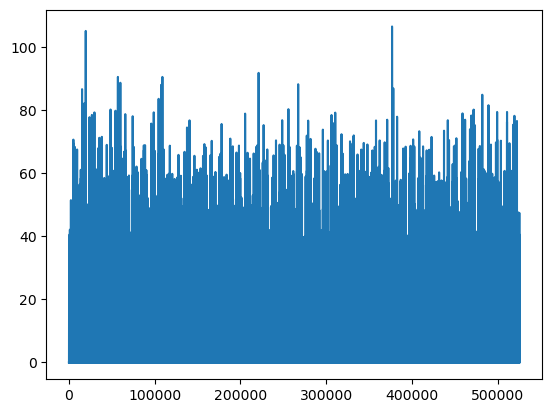

In [18]:
fig, ax = plt.subplots()
ax.plot(lp120['Charging Profile'])
#ax.plot(lp85['Charging Profile'])
#ax.plot(lp55['Charging Profile'])
#ax.plot(lp26['Charging Profile'])
#ax.plot(lp26_second_attempt['Charging Profile'])

## Single file

In [8]:
filename_2021 = f"{simulation_name}_apr_batt125_pv62_lp26_price2021.csv"
filename_2022 = f"{simulation_name}_apr_batt125_pv62_lp55_price2022.csv"

In [9]:
results_2021 = pd.read_csv(os.path.join(path_to_results_files, filename_2021), 
                      index_col='Unnamed: 0', parse_dates=True)
results_2022 = pd.read_csv(os.path.join(path_to_results_files, filename_2022), 
                      index_col='Unnamed: 0', parse_dates=True)

In [6]:
#results[datetime.datetime(2022,4,20):datetime.datetime(2022,4,20,12)]

In [10]:
results_2021.columns

Index(['timestamp', 'temperature', 'total_horizontal_irradiation',
       'diffuse_horizontal_irradiation', 'actions_heatpump_operation_modus',
       'actions_heatpump_compression_states', 'actions_heatpump_temp_setpoint',
       'actions_heatpump_flow_setpoint', 'actions_battery_system_status',
       'actions_battery_real_power', 'actions_battery_reactive_power',
       'actions_battery_reason', 'actions_chargingstation_totalpower',
       'actions_reset_heatpump_timer', 'actions_distr_heat_temp_sp',
       'costs_base_cs', 'costs_grid_cs', 'costs_cs_cost_calculated',
       'costs_base_el', 'costs_grid_el', 'costs_grid_only_solar',
       'costs_el_cost_calculated', 'costs_discounted_cost_calculated',
       'costs_pv', 'costs_battery', 'costs_savings_calculated',
       'costs_el_savings', 'costs_cs_savings', 'costs_el_savings_wout_battery',
       'costs_heat_cost_calculated', 'battery_state_of_charge',
       'battery_battery_status', 'battery_battery_operating_status',
       '

NameError: name 'results_2022' is not defined

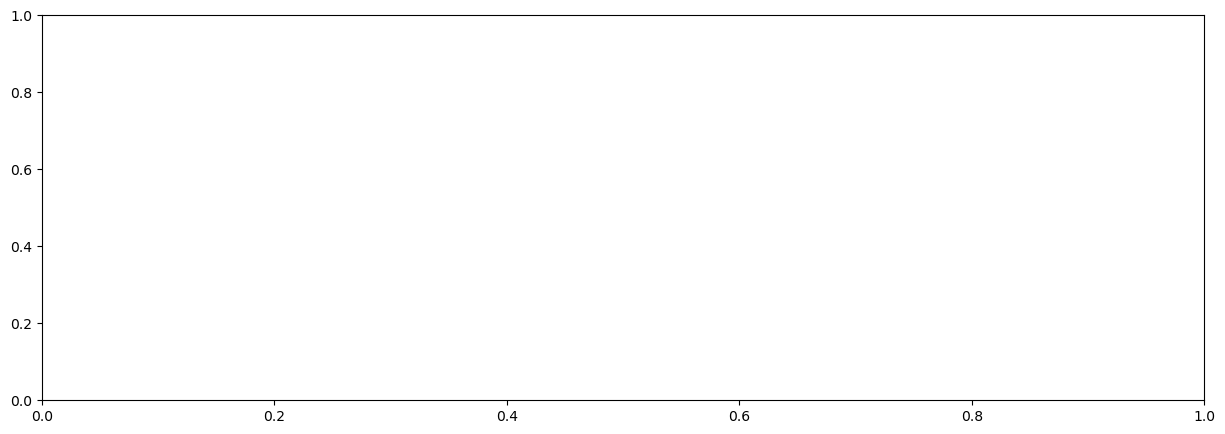

In [105]:
fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(results_2021['eldemand_total_load'], label='2021')
#ax.plot(results_2022['eldemand_total_load'], label='2022')
ax.plot(results_2022['pvinstallation_south_power'], label='pv south')
ax2=ax.twinx()
ax2.plot(results_2022['total_horizontal_irradiation'], 'r', label='2022')
#ax.plot(results['pvinstallation west_power'], label='pv west')
#ax.plot(results['pvinstallation_east_power'] + 
#        results['pvinstallation_south_power'] + 
#        results['pvinstallation_west_power'], label='pv total')
#ax.plot(results['eldemand_total_load'], label='demand total')
#ax.plot(results['battery_power'], label='battery power')
fig.legend()
ax.set_xlim(datetime.datetime(2022,4,20), datetime.datetime(2022,4,21))

(19102.0, 19107.0)

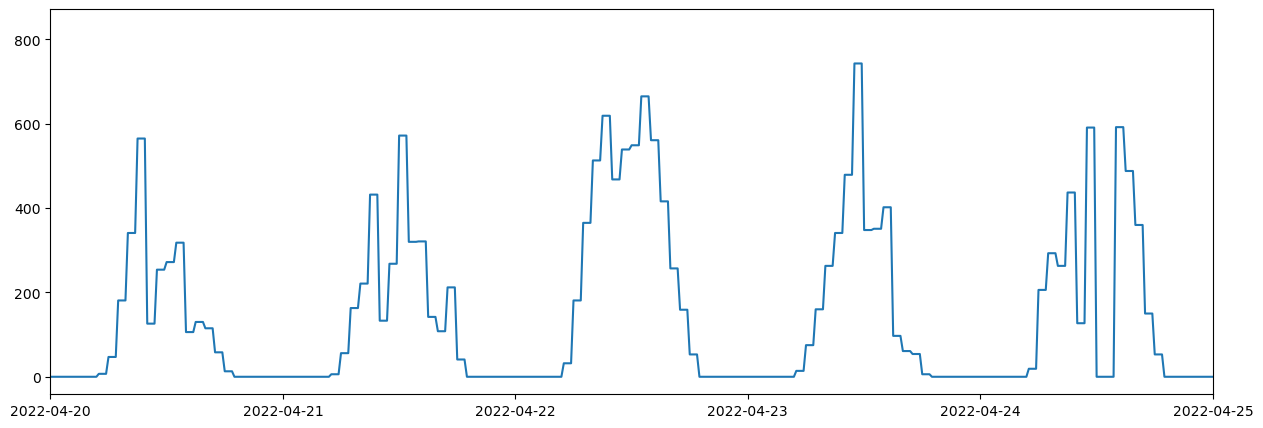

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results_2022['total_horizontal_irradiation'], label='2022')
ax.set_xlim(datetime.datetime(2022,4,20), datetime.datetime(2022,4,25))

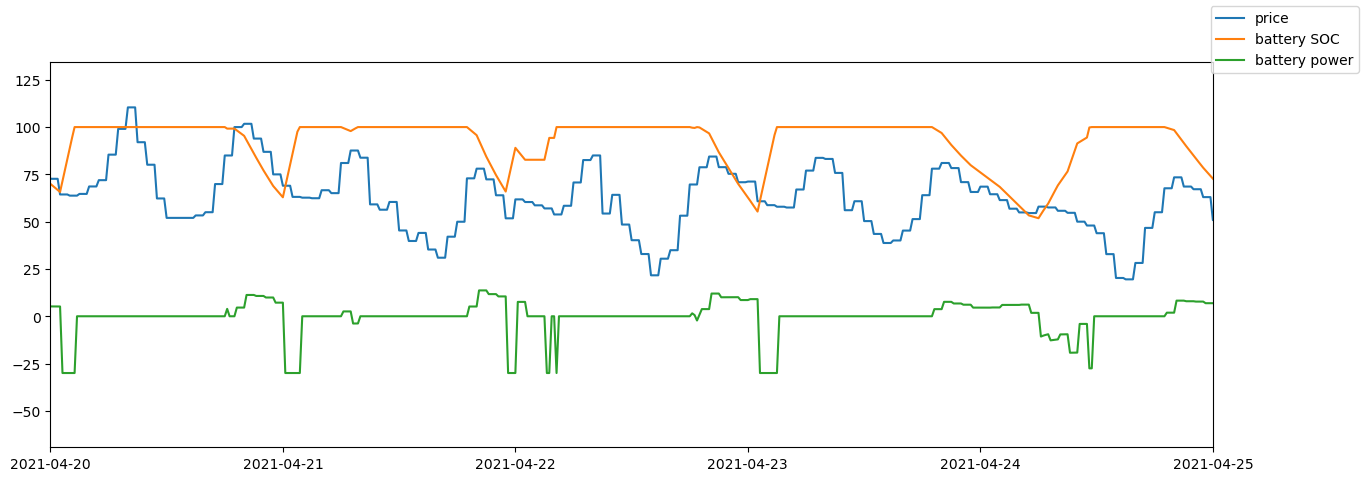

In [101]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['price_price']*1e6, label='price')
ax.plot(results['battery_state_of_charge'], label='battery SOC')
ax.plot(results['battery_power']/1000, label='battery power')
ax.set_xlim(datetime.datetime(2021,4,20), datetime.datetime(2021,4,25))
fig.legend()

# Nice figures

In [799]:
price = pd.read_csv(price_data, index_col='Time', parse_dates=True)

In [802]:
price_monthly = price.resample('M').mean()

In [846]:
months = ['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
selfconsumption_pv = [5.0,8.4,20.3,38.3,41.6,41.2,42.8,41.8,30.1,18.9,9.8,5.0]
selfconsumption = [10.5,16.7,29.7,48.4,52.0,52.1,54.9,52.9,43.4,30.1,17.0,9.6]
savings = [1614,1532,2398,2562,2425,2773,3793,5103,3207,1687,1546,1763]
payback_time = [7.044102335,7.42049939,4.740156588,4.437213683,4.687624804,4.099349696,
                2.99710657,2.227560115,3.545276382,6.740063331,7.35526074,6.4487977]
monthly_cost = 757.9

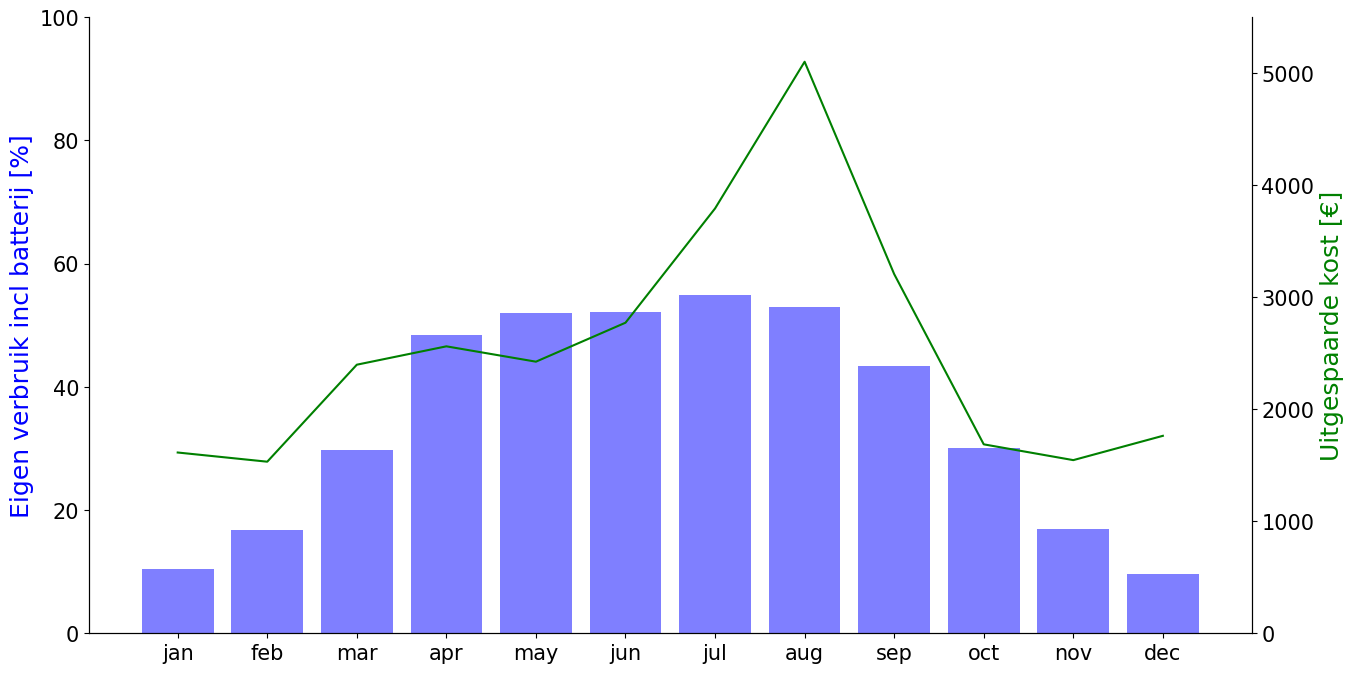

In [835]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(months, selfconsumption, label='Eigen verbruik incl batterij', color='b', alpha=0.5)
ax.set_ylim(0, 100)
ax.tick_params(labelsize=15)
ax.set_ylabel('Eigen verbruik incl batterij [%]', fontsize=18, color='b')

ax2 = ax.twinx()
ax2.plot(months, savings, label='Uitgespaarde kost', color='g')
ax2.set_ylim(0,5500)
ax2.tick_params(labelsize=15)
ax2.set_ylabel('Uitgespaarde kost [€]', fontsize=18, color='g')
#fig.legend(fontsize=15)
sns.despine(right=False)

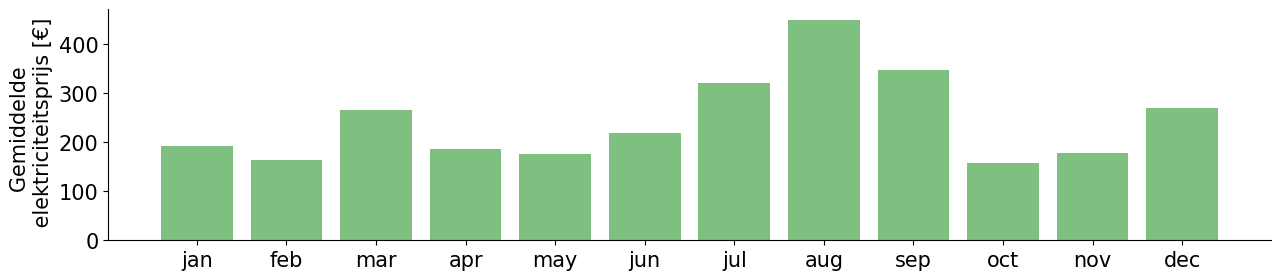

In [821]:
fix, ax = plt.subplots(figsize=(15,3))
ax.bar(months, price_monthly['price'], color='g', alpha=0.5)
ax.tick_params(labelsize=15)
ax.set_ylabel('Gemiddelde \n elektriciteitsprijs [€]', fontsize=15)
sns.despine()

In [828]:
[i - j for i, j in zip(selfconsumption, selfconsumption_pv)]

[5.5,
 8.299999999999999,
 9.399999999999999,
 10.100000000000001,
 10.399999999999999,
 10.899999999999999,
 12.100000000000001,
 11.100000000000001,
 13.299999999999997,
 11.200000000000003,
 7.199999999999999,
 4.6]

In [854]:
price_monthly['price']

Time
2022-01-31    191.409422
2022-02-28    162.618657
2022-03-31    265.950973
2022-04-30    186.598569
2022-05-31    176.642083
2022-06-30    219.105028
2022-07-31    321.349597
2022-08-31    448.152016
2022-09-30    346.504986
2022-10-31    157.386698
2022-11-30    177.905258
2022-12-31    269.277621
Freq: M, Name: price, dtype: float64

In [842]:
payback_time

[7.044102335,
 7.42049939,
 4.740156588,
 4.437213683,
 4.687624804,
 4.099349696,
 2.99710657,
 2.227560115,
 3.545276382,
 6.740063331,
 7.35526074,
 6.4487977]

In [847]:
savings_corrected = savings / price_monthly['price'] * 100 # with 100 the current average price

In [850]:
(15 / (savings_corrected / monthly_cost)).mean()

11.387747105534265

# Scraps

In [135]:
from pytz import timezone
tz = timezone("Europe/Brussels")

In [136]:
tz.utcoffset(datetime.datetime(2022,7,1)).seconds

7200

In [137]:
filepath = './data/weather_simulation.json'
metadata = {'temperature': dict,
                         'total_horizontal_irradiation': dict,
                         'diffuse_horizontal_irradiation': dict}
now = datetime.datetime(2022,7,1)
end = datetime.datetime(2022,8,1)

In [138]:
def filter_data(pair):
    # Throw away unused timestamps (keep 1 day before and after for peak calculation and timezone issues)
    key, value = pair
    if type(key) is not str:
        key = key.strftime("%Y-%m-%d %H:%M:%S")
    if key < (now - datetime.timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S") or key > (end + datetime.timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S"):
        return False
    else:
        return True

In [139]:
with open(filepath, 'r') as f:
    data = f.read()
# remove timestamps after end_time (speeds up simulation process)
input_data = json.loads(data)

In [140]:
d = {}
for name in metadata.keys():
    d[name] = dict(filter(filter_data, input_data[name].items()))
data = d

In [141]:
for key, series in data.items():
    data[key] = {now + datetime.timedelta(seconds=900) * i: float(v)
                 for i, v in zip(range(0, len(series)), series.values())}

data = pd.DataFrame(data)

In [156]:
data.index#.freq

DatetimeIndex(['2022-07-01 00:00:00', '2022-07-01 00:15:00',
               '2022-07-01 00:30:00', '2022-07-01 00:45:00',
               '2022-07-01 01:00:00', '2022-07-01 01:15:00',
               '2022-07-01 01:30:00', '2022-07-01 01:45:00',
               '2022-07-01 02:00:00', '2022-07-01 02:15:00',
               ...
               '2022-08-01 21:45:00', '2022-08-01 22:00:00',
               '2022-08-01 22:15:00', '2022-08-01 22:30:00',
               '2022-08-01 22:45:00', '2022-08-01 23:00:00',
               '2022-08-01 23:15:00', '2022-08-01 23:30:00',
               '2022-08-01 23:45:00', '2022-08-02 00:00:00'],
              dtype='datetime64[ns]', length=3073, freq=None)

In [143]:
pd.to_timedelta(pd.infer_freq(data.index)).seconds

900

In [157]:
data.sort_index().index[0]#.to_pydatetime()

Timestamp('2022-07-01 00:00:00')

In [158]:
d = {k: {t.timestamp(): v 
         for t, v in data[k].to_dict().items()} for k in data.columns} #

In [146]:
#df = pd.DataFrame(d)
#df[datetime.datetime(2022, 7, 1, 0, 0):datetime.datetime(2022, 7, 1, 12, 0)]

In [147]:
#df.index[0]

In [159]:
d['total_horizontal_irradiation']

{1656633600.0: 0.0,
 1656634500.0: 0.0,
 1656635400.0: 0.0,
 1656636300.0: 0.0,
 1656637200.0: 0.0,
 1656638100.0: 0.0,
 1656639000.0: 0.0,
 1656639900.0: 0.0,
 1656640800.0: 0.0,
 1656641700.0: 0.0,
 1656642600.0: 0.0,
 1656643500.0: 0.0,
 1656644400.0: 0.0,
 1656645300.0: 0.0,
 1656646200.0: 0.0,
 1656647100.0: 0.0,
 1656648000.0: 5.0,
 1656648900.0: 5.0,
 1656649800.0: 5.0,
 1656650700.0: 5.0,
 1656651600.0: 56.0,
 1656652500.0: 56.0,
 1656653400.0: 56.0,
 1656654300.0: 56.0,
 1656655200.0: 110.0,
 1656656100.0: 110.0,
 1656657000.0: 110.0,
 1656657900.0: 110.0,
 1656658800.0: 200.0,
 1656659700.0: 200.0,
 1656660600.0: 200.0,
 1656661500.0: 200.0,
 1656662400.0: 126.0,
 1656663300.0: 126.0,
 1656664200.0: 126.0,
 1656665100.0: 126.0,
 1656666000.0: 223.0,
 1656666900.0: 223.0,
 1656667800.0: 223.0,
 1656668700.0: 223.0,
 1656669600.0: 193.0,
 1656670500.0: 193.0,
 1656671400.0: 193.0,
 1656672300.0: 193.0,
 1656673200.0: 465.0,
 1656674100.0: 465.0,
 1656675000.0: 465.0,
 165667590

In [163]:
# + tz.utcoffset(datetime.datetime.fromtimestamp(t))
pd.DataFrame(data=d['total_horizontal_irradiation'].values(),
             index=[datetime.datetime.fromtimestamp(t) for t in d['total_horizontal_irradiation'].keys()]).shift(8).fillna(method='bfill').to_dict()

TypeError: slice indices must be integers or None or have an __index__ method

In [155]:
datetime.datetime.fromtimestamp(1656633600.0)

datetime.datetime(2022, 7, 1, 2, 0)

In [119]:
datetime.datetime(2022,1,1).timestamp()

1640991600.0

In [121]:
tz.localize(datetime.datetime(2022,1,1)).timestamp()

1640991600.0